In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from keras.optimizers import SGD
from keras.layers import Dense, Flatten, Input, Activation
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Dropout
import keras

import h5py  # compress and save features

# Loading data

In [2]:
%%time
with h5py.File('features_train.h5', 'r') as f:
    features = np.array(f['features'])

Wall time: 5min 10s


In [3]:
features.shape

(244768, 9736)

In [ ]:
%%time
with h5py.File('features_all_train.h5', 'r') as f:
    feature_combine = np.array(f['feature_all'])

In [ ]:
feature_combine.shape

In [4]:
%%time
with h5py.File('features_salary.h5', 'r') as f:
    salary = np.array(f['salary'])

Wall time: 666 ms


In [5]:
salary.shape

(244768,)

In [6]:
salary_log = np.log(salary)

In [14]:
%%time
with h5py.File('features_test.h5', 'r') as f:
    feature_test = np.array(f['features_test'])

Wall time: 2min 33s


In [15]:
feature_test.shape

(122463, 9736)

**observe salary**

In [17]:
true_salay_dataset = pd.read_csv('./dataset/random_forest_benchmark_test_rev1.csv')

In [18]:
ture_salay = true_salay_dataset['SalaryNormalized']

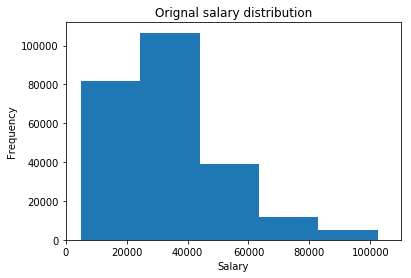

In [16]:
f1 = plt.figure(1)
plt.hist(salary)
plt.title('Orignal salary distribution')  
plt.ylabel("Frequency")  
plt.xlabel("Salary")
# plt with same scale
#plt.ylim(0,0.25)
plt.xlim(0,110000)
plt.savefig("Orignal salary distribution.PNG", dpi = 600)
plt.show()

**It could find the distribution of salay is not Gauusian, therefore, take log to this data**

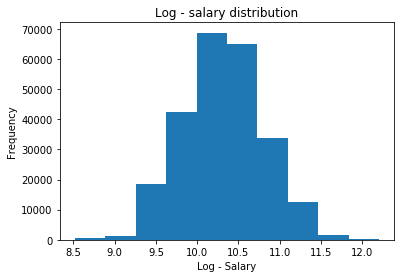

In [18]:
# make a histogram of the data array
salary_log = np.log(salary)
 
f1 = plt.figure(2)
plt.hist(salary_log)
plt.title('Log - salary distribution')  
plt.ylabel("Frequency")  
plt.xlabel("Log - Salary")
# plt with same scale
#plt.ylim(0,0.25)
#plt.xlim(0,110000)
plt.savefig("Log - salary distribution.PNG", dpi = 600)
plt.show()

# PCA analysis

In [ ]:
def zeroMean(dataMat):        
    meanVal=np.mean(dataMat,axis=0)     #get mean by columns
    newData=dataMat-meanVal  
    return newData,meanVal


def percentage2n(eigVals,percentage):  
    sortArray=np.sort(eigVals)          #ascend order 
    sortArray=sortArray[-1::-1]           
    arraySum=sum(sortArray)  
    tmpSum=0  
    num=0  
    for i in sortArray:  
        tmpSum+=i  
        num+=1  
        if tmpSum>=arraySum*percentage:  
            return num  


def pca(dataMat,percentage=0.99):  
    newData,meanVal=zeroMean(dataMat)  
    covMat=np.cov(newData,rowvar=0)      #covariance  
    eigVals,eigVects=np.linalg.eig(np.mat(covMat))      
    n=percentage2n(eigVals,percentage)                 #need n dimensionol data to get the convariance percentage
    eigValIndice=np.argsort(eigVals)            #ascend order 
    n_eigValIndice=eigValIndice[-1:-(n+1):-1]   
    n_eigVect=eigVects[:,n_eigValIndice]        
    lowDDataMat=newData*n_eigVect               #lower dimensional data  
    #reconMat=(lowDDataMat*n_eigVect.T)+meanVal  #reconstruct data  
    return lowDDataMat,n

**dimention too big to use this pca function**

# create train and test datasets

In [ ]:
x_train = features[0:122384]
x_train.shape

In [27]:
x_test = features[122384:244768]
x_test.shape

(122384, 9736)

In [ ]:
y_train = salary[0:122384]
y_train.shape

In [28]:
y_test = salary[122384:244768]
y_test.shape

(122384,)

In [29]:
y_test = np.log(y_test)

In [ ]:
del features, salary

# build model

In [19]:
# create model
model = Sequential()
model.add(Dense(3000,input_dim=9736, activation='relu',use_bias=True))
#model.add(Dense(4000,input_dim=9736, activation='relu',use_bias=True)) # without fulldescription
model.add(Dropout(0.5))
model.add(Dense(1500, activation='relu',use_bias=True))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu',use_bias=True))
model.add(Dropout(0.5))
model.add(Dense(1))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3000)              29211000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1500)              4501500   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1500)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
_________________________________________________________________
den

In [20]:
# Change log_dir for differnt activation function, change the number for every run.
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard/3000-1500-1000-adam', histogram_freq=0, write_graph=True, write_images=True)

**GTX960M  batch_size:1024  using around 50% of memory**

In [22]:
hist = model.fit(features, salary_log, batch_size=1024, epochs=100, shuffle=True,verbose=2,validation_split=0.2, callbacks = [tbCallBack])  

Train on 195814 samples, validate on 48954 samples
Epoch 1/100
 - 95s - loss: 22332891.1447 - val_loss: 12929.3978
Epoch 2/100
 - 98s - loss: 13113.8887 - val_loss: 11914.2255
Epoch 3/100
 - 101s - loss: 12033.5939 - val_loss: 10812.1000
Epoch 4/100
 - 97s - loss: 10840.9043 - val_loss: 9724.7503
Epoch 5/100
 - 98s - loss: 9771.0594 - val_loss: 8676.6102
Epoch 6/100
 - 99s - loss: 8686.3623 - val_loss: 7690.3445
Epoch 7/100
 - 98s - loss: 7703.1771 - val_loss: 6772.6240
Epoch 8/100
 - 98s - loss: 6787.5582 - val_loss: 5940.2919
Epoch 9/100
 - 95s - loss: 5953.6878 - val_loss: 5192.4488
Epoch 10/100
 - 96s - loss: 5208.2251 - val_loss: 4525.9952
Epoch 11/100
 - 98s - loss: 4538.9236 - val_loss: 3933.8009
Epoch 12/100
 - 93s - loss: 3964.9334 - val_loss: 3414.9885
Epoch 13/100
 - 95s - loss: 3438.1585 - val_loss: 2957.9668
Epoch 14/100
 - 100s - loss: 2994.9079 - val_loss: 2560.5042
Epoch 15/100
 - 94s - loss: 2597.9756 - val_loss: 2211.2572
Epoch 16/100
 - 97s - loss: 2247.9089 - val_lo

**Save model**

In [26]:
model.save('model_1.h5')

**Evalueate in test data**

In [37]:
salay_predict = model.predict(feature_test)
# obtain orignal salay
salay_predict = np.exp(salay_predict)

In [64]:
mse = 0
for n in range(0,len(ture_salay)):
    diff = abs(ture_salay[n] - salay_predict[n])
    diff_square = np.square(diff)
    mse = mse + diff_square
mse

array([1.1708856e+14], dtype=float32)

**Result so bad**

# Adding earlystopping, BatchNormalization AND Change to sgd opt

In [10]:
# create model
model = Sequential()
model.add(Dense(4000,input_dim=9736, init='uniform'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, init='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))


# Compile model
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer='sgd')
print(model.summary())

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4000, kernel_initializer="uniform", input_dim=9736)`
  app.launch_new_instance()
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`
E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform")`


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4000)              38948000  
_________________________________________________________________
batch_normalization_1 (Batch (None, 4000)              16000     
_________________________________________________________________
activation_1 (Activation)    (None, 4000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              4001000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
_________________________________________________________________
act

In [11]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
# Change log_dir for differnt activation function, change the number for every run.
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tensorboard/0', histogram_freq=0, write_graph=True, write_images=True)

In [12]:
hist = model.fit(features, salary_log, batch_size=1024, epochs=100, shuffle=True,verbose=2,validation_split=0.05, callbacks = [tbCallBack,early_stopping_monitor])  

Train on 232529 samples, validate on 12239 samples
Epoch 1/100
 - 110s - loss: 67.6266 - val_loss: 0.2725
Epoch 2/100
 - 99s - loss: 0.2392 - val_loss: 0.2289
Epoch 3/100
 - 96s - loss: 0.2321 - val_loss: 0.2251
Epoch 4/100
 - 96s - loss: 0.2316 - val_loss: 0.2245
Epoch 5/100
 - 97s - loss: 0.2316 - val_loss: 0.2241
Epoch 6/100
 - 99s - loss: 0.2310 - val_loss: 0.2235
Epoch 7/100
 - 99s - loss: 0.2307 - val_loss: 0.2230
Epoch 8/100
 - 91s - loss: 0.2301 - val_loss: 0.2223
Epoch 9/100
 - 97s - loss: 0.2297 - val_loss: 0.2216
Epoch 10/100
 - 94s - loss: 0.2293 - val_loss: 0.2209
Epoch 11/100
 - 95s - loss: 0.2287 - val_loss: 0.2204
Epoch 12/100
 - 96s - loss: 0.2283 - val_loss: 0.2198
Epoch 13/100
 - 94s - loss: 0.2280 - val_loss: 0.2194
Epoch 14/100
 - 94s - loss: 0.2277 - val_loss: 0.2188
Epoch 15/100
 - 95s - loss: 0.2272 - val_loss: 0.2182
Epoch 16/100
 - 95s - loss: 0.2269 - val_loss: 0.2180
Epoch 17/100
 - 88s - loss: 0.2257 - val_loss: 0.2153
Epoch 18/100
 - 87s - loss: 0.2248 - v

In [13]:
model.save('model_2.h5')

** It could find the early stopping used**

**Evalueate in test data**

In [16]:
%%time
salay_predict = model.predict(feature_test)
# obtain orignal salay
salay_predict = np.exp(salay_predict)

Wall time: 42.3 s


In [19]:
mse = 0
for n in range(0,len(ture_salay)):
    diff = abs(ture_salay[n] - salay_predict[n])
    diff_square = np.square(diff)
    mse = mse + diff_square
mse = mse/len(ture_salay)
mse

array([1.09342409e+08])

In [26]:
avrage_data = np.sqrt(mse)/np.mean(ture_salay)
print('average diff of predicted data is ',avrage_data*100,'%')

average diff of predicted data is  [30.56017192] %


**Result still not good**

# Adding earlystopping, BatchNormalization AND Change to adam opt